## Business Problem/Stakeholders
 
 We (Antom Research) are based in King County and working on a project for a real estate investment trust. They would like us to use our area expertise to advise them on what sort of properties are likely to maximize the value of their investment. They have been tight-lipped about their plans for the properties they purchase, so we do not know if they intend to buy and hold, rennovate, demolish and rebuild, etc.
 
   
     
     

## Data Understanding

Address limitations of data. Target properties below the expected price_sqft in appealing zip codes.
Very few properties that demonstrate 

# Data Understanding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.linear_model import LinearRegression

In [2]:
# Import Housing Data
simple_housing = pd.read_csv('../data/kc_house_data.csv')
simple_housing.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [3]:
# Define & Remove Out of Scope Features
complexities = ['id','date', 'view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'lat', 'long', 'zipcode', 'sqft_living15', 'sqft_lot15']
simple_housing.drop(columns=complexities, inplace=True)
simple_housing.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
0,221900.0,3,1.00,1180,5650,1.0,NaN,Average,7 Average,1955
1,538000.0,3,2.25,2570,7242,2.0,NO,Average,7 Average,1951
2,180000.0,2,1.00,770,10000,1.0,NO,Average,6 Low Average,1933
3,604000.0,4,3.00,1960,5000,1.0,NO,Very Good,7 Average,1965
4,510000.0,3,2.00,1680,8080,1.0,NO,Average,8 Good,1987


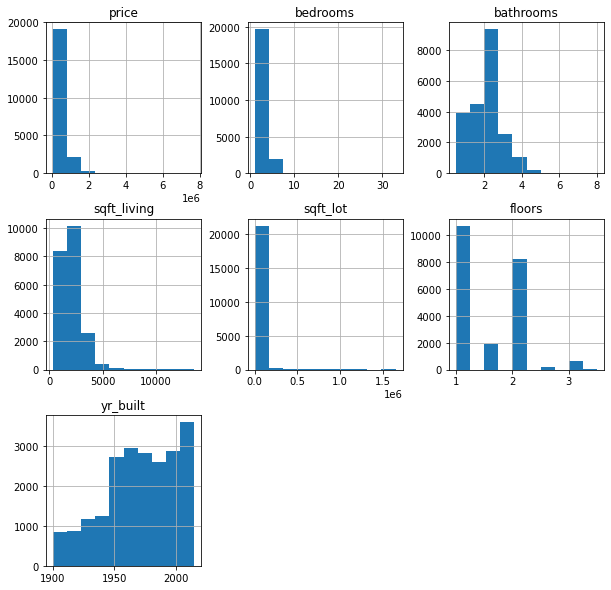

In [4]:
# Exploratory Visualizations

import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (10,10))
ax = fig.gca()
simple_housing.hist(ax = ax);

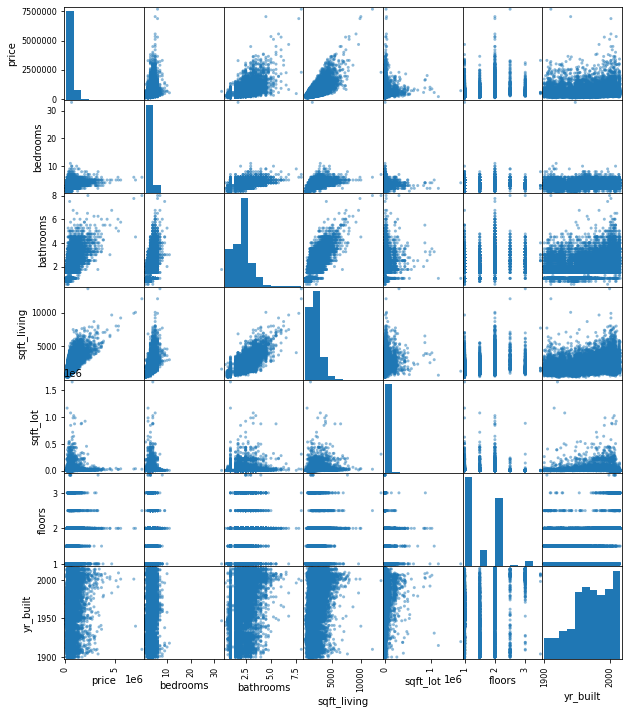

In [5]:
# scatter matrix
pd.plotting.scatter_matrix(simple_housing, figsize=(10,12));

# Data Preparation & Feature Engineering


Because we aim to maximize the value of our clients' investment, we do not believe home price is the most meaningful target variable. Certainly a higher sale price is appealing, but we must also consider the risk that comes with large individual investments. Expensive homes have a limited pool of buyers, even in a wealthy locale like King County. We will focus our analysis on the price per square foot of the properties in our data in order to allow our clients to make investment decisions that match their specific fund sizes and risk tolerances.

We elect to drop the waterfront feature from our analysis because only ~133 properties in the dataset can be definitively described as waterfront. We also drop the one instance of a building grade 3, as this code signifies that the property fails to meet minimum building standards and could be unsafe..

In [6]:
# Add price per square foot feature
simple_housing['price_sqft'] = simple_housing['price'] / simple_housing['sqft_living']

# drop waterfront, components of price_sqft, and poor graded structure & confirm no NaNs
simple_housing = simple_housing.drop(columns=['waterfront', 'price', 'sqft_living'])
simple_housing = simple_housing[simple_housing['grade']!='3 Poor']

# drop the one instance of of "poor" grade building materials in the dataset. 
simple_housing.isna().sum()

bedrooms      0
bathrooms     0
sqft_lot      0
floors        0
condition     0
grade         0
yr_built      0
price_sqft    0
dtype: int64

In [7]:
# Train/test split
X = simple_housing.drop(columns=['price_sqft'])
y = simple_housing['price_sqft']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=40, test_size=0.33)

In [8]:
# Encode Categorical Variables in Test & Train data.

# Identify catgeorical values & create new df with only the categorical columns.
categoricals = ['condition', 'grade']
X_train_cats = X_train[categoricals]
X_test_cats = X_test[categoricals]

In [9]:
# OneHot encoding for categorical variables in Train data. Drop first column to avoid perfect multicolinearity.
ohe = OneHotEncoder(drop='first')
X_train_cats_encoded = ohe.fit_transform(X_train_cats)
X_train_cats_df = pd.DataFrame(X_train_cats_encoded.todense(), columns=ohe.get_feature_names(categoricals))

In [10]:
# Confirm identical # of records before concatenating.
print(X_train_cats_df.shape)
print(X_train.shape)

(14469, 13)
(14469, 7)


In [11]:
# Drop original categorical columns, concatenate encoded columns.
X_train_data = X_train.drop(columns=categoricals)
X_train_encoded = pd.concat([X_train_data.reset_index(drop=True), X_train_cats_df.reset_index(drop=True)], axis=1)

In [12]:
# Confirm no new records added, dtypes=in or float, categoricals are gone.
print(X_train_encoded.shape)
X_train_encoded.info()

(14469, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14469 entries, 0 to 14468
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bedrooms             14469 non-null  int64  
 1   bathrooms            14469 non-null  float64
 2   sqft_lot             14469 non-null  int64  
 3   floors               14469 non-null  float64
 4   yr_built             14469 non-null  int64  
 5   condition_Fair       14469 non-null  float64
 6   condition_Good       14469 non-null  float64
 7   condition_Poor       14469 non-null  float64
 8   condition_Very Good  14469 non-null  float64
 9   grade_11 Excellent   14469 non-null  float64
 10  grade_12 Luxury      14469 non-null  float64
 11  grade_13 Mansion     14469 non-null  float64
 12  grade_4 Low          14469 non-null  float64
 13  grade_5 Fair         14469 non-null  float64
 14  grade_6 Low Average  14469 non-null  float64
 15  grade_7 Average      144

In [13]:
# OneHot encoding for categorical variables in Test data.
ohe = OneHotEncoder(drop='first')
X_test_cats_encoded = ohe.fit_transform(X_test_cats)
X_test_cats_df = pd.DataFrame(X_test_cats_encoded.todense(), columns=ohe.get_feature_names(categoricals))
X_test_data = X_test.drop(columns=categoricals)
X_test_encoded = pd.concat([X_test_data.reset_index(drop=True), X_test_cats_df.reset_index(drop=True)], axis=1)
X_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7127 entries, 0 to 7126
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bedrooms             7127 non-null   int64  
 1   bathrooms            7127 non-null   float64
 2   sqft_lot             7127 non-null   int64  
 3   floors               7127 non-null   float64
 4   yr_built             7127 non-null   int64  
 5   condition_Fair       7127 non-null   float64
 6   condition_Good       7127 non-null   float64
 7   condition_Poor       7127 non-null   float64
 8   condition_Very Good  7127 non-null   float64
 9   grade_11 Excellent   7127 non-null   float64
 10  grade_12 Luxury      7127 non-null   float64
 11  grade_13 Mansion     7127 non-null   float64
 12  grade_4 Low          7127 non-null   float64
 13  grade_5 Fair         7127 non-null   float64
 14  grade_6 Low Average  7127 non-null   float64
 15  grade_7 Average      7127 non-null   f

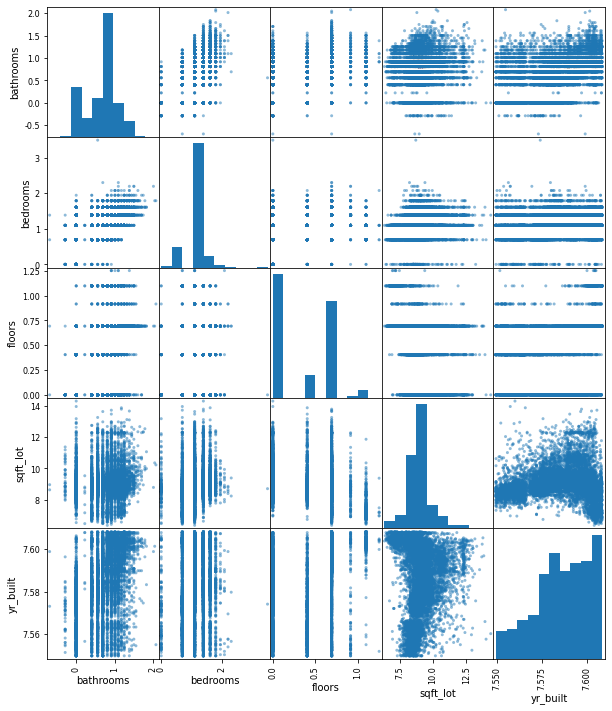

In [14]:
# log-transform non-normal features of Train Data
non_normal = ['bathrooms', 'bedrooms', 'floors', 'sqft_lot', 'yr_built']
train_preds_log = pd.DataFrame([])
train_preds_log[non_normal] = np.log(X_train_encoded[non_normal])
train_preds_log = pd.concat([train_preds_log.reset_index(drop=True), X_train_encoded.iloc[:,6:].reset_index(drop=True)], axis=1)

# log-transform non-normal features of Test Data
test_preds_log = pd.DataFrame([])
test_preds_log[non_normal] = np.log(X_test_encoded[non_normal])
test_preds_log = pd.concat([test_preds_log.reset_index(drop=True), X_test_encoded.iloc[:,6:].reset_index(drop=True)], axis=1)

# Visualize Impact of Logged Train Preds
pd.plotting.scatter_matrix(train_preds_log[non_normal], figsize=(10,12));

In [15]:
# Perform scaling of our training data utilizing StandardScaler
ss = StandardScaler()

X_train_scaled = ss.fit_transform(train_preds_log)
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=train_preds_log.index, columns=train_preds_log.columns)
X_train_scaled_df.head()

,bathrooms,bedrooms,floors,sqft_lot,yr_built,condition_Good,condition_Poor,condition_Very Good,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better
0,-0.311462,-0.282324,-0.967464,0.398620,0.274225,1.674702,-0.038125,-0.292312,-0.138934,-0.062333,-0.02352,-0.035293,-0.10235,-0.323531,1.198444,-0.631171,-0.373698
1,0.599230,-0.282324,-0.967464,3.206710,-0.131784,-0.597121,-0.038125,-0.292312,-0.138934,-0.062333,-0.02352,-0.035293,-0.10235,-0.323531,-0.834415,1.584358,-0.373698
2,-0.705052,-1.711758,0.994292,1.124851,0.644242,-0.597121,-0.038125,-0.292312,-0.138934,-0.062333,-0.02352,-0.035293,-0.10235,-0.323531,1.198444,-0.631171,-0.373698
3,-1.740318,1.518549,0.180090,0.372202,-1.920261,-0.597121,-0.038125,-0.292312,-0.138934,-0.062333,-0.02352,-0.035293,-0.10235,-0.323531,1.198444,-0.631171,-0.373698
4,1.458338,0.731875,0.994292,3.416798,1.112227,-0.597121,-0.038125,-0.292312,-0.138934,-0.062333,-0.02352,-0.035293,-0.10235,-0.323531,-0.834415,-0.631171,2.675957


In [16]:
# Perform scaling of our test data utilizing StandardScaler
X_test_scaled = ss.fit_transform(test_preds_log)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=test_preds_log.index, columns=test_preds_log.columns)
X_test_scaled_df.head()

,bathrooms,bedrooms,floors,sqft_lot,yr_built,condition_Good,condition_Poor,condition_Very Good,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better
0,-1.700255,-0.275331,-0.947796,-0.642114,-0.944843,1.674245,-0.033522,-0.292301,-0.133612,-0.068204,-0.026496,-0.035558,-0.114357,3.112099,-0.861215,-0.612215,-0.366019
1,-0.279448,-0.275331,-0.947796,-0.737867,-1.813300,1.674245,-0.033522,-0.292301,-0.133612,-0.068204,-0.026496,-0.035558,-0.114357,3.112099,-0.861215,-0.612215,-0.366019
2,1.089009,0.745458,1.032771,0.037071,1.261879,-0.597284,-0.033522,-0.292301,-0.133612,-0.068204,-0.026496,-0.035558,-0.114357,-0.321327,-0.861215,-0.612215,2.732100
3,0.626113,-0.275331,1.032771,-0.022547,0.556847,-0.597284,-0.033522,-0.292301,-0.133612,-0.068204,-0.026496,-0.035558,-0.114357,-0.321327,-0.861215,-0.612215,2.732100
4,-0.279448,-1.714052,-0.947796,-0.214100,-0.772493,-0.597284,-0.033522,-0.292301,-0.133612,-0.068204,-0.026496,-0.035558,-0.114357,-0.321327,1.161150,-0.612215,-0.366019


## Dummy Regressor

We begin modelling efforts by creating a dummy regressor model to provide a baseline. The R2 value produced of 30 should not be difficult for us to beat.

In [17]:
# Code Credit to geeksforgeeks.org. https://www.geeksforgeeks.org/dummy-regressor/
lm = LinearRegression().fit(X_train_scaled, y_train)
lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train_scaled, y_train) 
lm_dummy_median = DummyRegressor(strategy = 'median').fit(X_train_scaled, y_train)
y_predict = lm.predict(X_test_scaled)
y_predict_dummy_mean = lm_dummy_mean.predict(X_test_scaled)
y_predict_dummy_median = lm_dummy_median.predict(X_test_scaled)

In [18]:
print('Linear model, coefficients: ', lm.coef_)
print("Mean squared error (dummy): {:.2f}".format(mean_squared_error(y_test, y_predict_dummy_mean)))
print("Mean squared error (linear model): {:.2f}".format(mean_squared_error(y_test, y_predict)))

print("Median absolute error (dummy): {:.2f}".format(median_absolute_error(y_test, y_predict_dummy_median)))
print("Median absolute error (linear model): {:.2f}".format(median_absolute_error(y_test, y_predict)))

print("r2_score (dummy mean): {:.2f}".format(r2_score(y_test, y_predict_dummy_mean)))
print("r2_score (dummy median): {:.2f}".format(r2_score(y_test, y_predict_dummy_median)))
print("r2_score (linear model): {:.2f}".format(r2_score(y_test, y_predict)))


Linear model, coefficients:  [ -8.30364274 -27.99783824   1.81874256 -22.65028495 -45.07618738
   1.89316308  -1.21013814   4.83813619   6.09084649   8.39654942
   4.80586773  -5.87735973 -21.33072093 -55.23172783 -73.40617379
 -47.41281988 -17.95014621]
Mean squared error (dummy): 12190.92
Mean squared error (linear model): 8557.65
Median absolute error (dummy): 66.66
Median absolute error (linear model): 55.24
r2_score (dummy mean): -0.00
r2_score (dummy median): -0.03
r2_score (linear model): 0.30


## First Simple Model

The year in which the house was built is the most correlated variable with price per square foot. The negative correlation might mean that buyers in King county value older houses at a higher rate than new-builds. We began our analysis by modelling the log-scaled and standardized year in which the houses were constructed against the price per square foot. Unsurprisingly, the model is quite weak wtih an R^2 value of 0.012. We will move from here to a multiple linear regression model that considers all of the variables in our test data. 

In [19]:
# add constant term/y-intercept to train data
X_train_preds = sm.add_constant(X_train_scaled_df)
X_test_preds = sm.add_constant(X_test_scaled_df)

In [20]:
# Reshape y_train to facilitate modeling against X_train
y_train=y_train.values.reshape(-1,1)
model = sm.OLS(endog=y_train, exog=X_train_preds['yr_built']).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.012
Model:                            OLS   Adj. R-squared (uncentered):              0.012
Method:                 Least Squares   F-statistic:                              179.9
Date:                Wed, 22 Jun 2022   Prob (F-statistic):                    8.96e-41
Time:                        19:32:03   Log-Likelihood:                     -1.0228e+05
No. Observations:               14469   AIC:                                  2.046e+05
Df Residuals:                   14468   BIC:                                  2.046e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
yr_built     -31.6906      2.363    -13.412      0.000     -36.322     -27.059
==============================================================================
Omnibus:                     2739.693   Durbin-Watson:                   0.274
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5697.114
Skew:                           1.122   Prob(JB):                         0.00
Kurtosis:                       5.101   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## First Multiple Linear Regression Model

R^2 value is much improved over our simple model, but still quite low. We will likely need to add additional features in order to improve the model. From our original dataset, zipcode is an appealing proxy for several attributes of a home, i.e. school district, proximity to amenities, etc. We will include the effect of zip code on price_sqft in our next model.

In [21]:
# First model
model = sm.OLS(endog=y_train, exog=X_train_preds).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     363.2
Date:                Wed, 22 Jun 2022   Prob (F-statistic):               0.00
Time:                        19:32:03   Log-Likelihood:                -85939.
No. Observations:               14469   AIC:                         1.719e+05
Df Residuals:                   14451   BIC:                         1.721e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 264.0528      0.764    345.440      0.000     262.554     265.551
bathrooms              -8.3036      1.235     -6.723      0.000     -10.724      -5.883
bedrooms              -27.9978      0.935    -29.931      0.000     -29.831     -26.164
floors                  1.8187      1.022      1.779      0.075      -0.185       3.822
sqft_lot              -22.6503      0.863    -26.240      0.000     -24.342     -20.958
yr_built              -45.0762      1.019    -44.215      0.000     -47.074     -43.078
condition_Good          1.8932      0.838      2.258      0.024       0.250       3.536
condition_Poor         -1.2101      0.770     -1.571      0.116      -2.720       0.300
condition_Very Good     4.8381      0.828      5.841      0.000       3.215       6.462
grade_11 Excellent      6.0908      0.885      6.880      0.000       4.356       7.826
grade_12 Luxury         8.3965      0.793     10.591      0.000       6.843       9.951
grade_13 Mansion        4.8059      0.769      6.246      0.000       3.298       6.314
grade_4 Low            -5.8774      0.785     -7.486      0.000      -7.416      -4.338
grade_5 Fair          -21.3307      0.885    -24.095      0.000     -23.066     -19.595
grade_6 Low Average   -55.2317      1.453    -38.023      0.000     -58.079     -52.384
grade_7 Average       -73.4062      1.958    -37.483      0.000     -77.245     -69.568
grade_8 Good          -47.4128      1.714    -27.666      0.000     -50.772     -44.054
grade_9 Better        -17.9501      1.321    -13.588      0.000     -20.540     -15.361
==============================================================================
Omnibus:                     2703.639   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6653.440
Skew:                           1.041   Prob(JB):                         0.00
Kurtosis:                       5.589   Cond. No.                         6.98
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

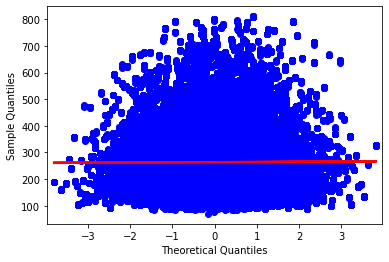

In [22]:
# Checking for normality

# Calculate our residuals
mod1_train_residuals = y_train - X_train_preds
mod1_test_residuals = y_test - X_test_preds

#plt.hist(mod1_train_residuals, label='Train')


# QQ Plot
sm.qqplot(mod1_train_residuals, line = 'r');

#sm.qqplot(train_residuals, line = 'r');

In [23]:
# Test for Multicolinearity

# defining an empty dataframe to capture the VIF scores
vif = pd.DataFrame()

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score
vif["VIF"] = [variance_inflation_factor(X_train_preds.values, i) for i in range(len(X_train_preds.columns))]

# label the scores with their related columns
vif["features"] = X_train_preds.columns

vif

,VIF,features
0,1.000000,const
1,2.610524,bathrooms
2,1.497483,bedrooms
3,1.788415,floors
4,1.275259,sqft_lot
5,1.778742,yr_built
6,1.202837,condition_Good
7,1.015523,condition_Poor
8,1.174045,condition_Very Good
9,1.341157,grade_11 Excellent


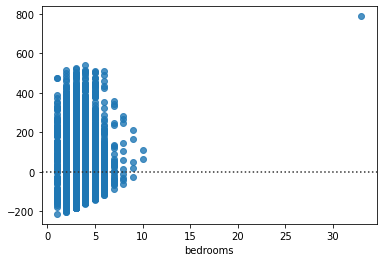

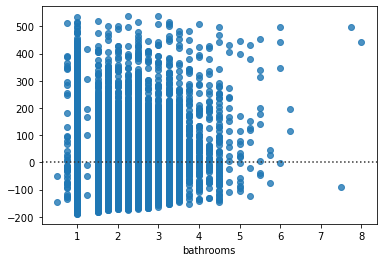

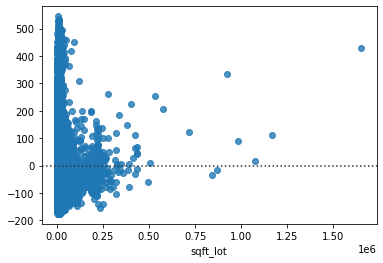

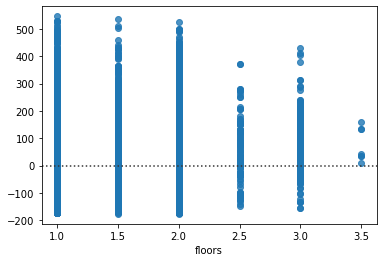

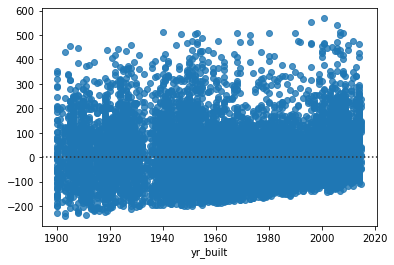

In [25]:
# Check Residual Plots

sns.residplot(x=X_train['bedrooms'], y=y_train)
plt.show()

sns.residplot(x=X_train['bathrooms'], y=y_train)
plt.show()

sns.residplot(x=X_train['sqft_lot'], y=y_train)
plt.show()

sns.residplot(x=X_train['floors'], y=y_train)
plt.show()

sns.residplot(x=X_train['yr_built'], y=y_train)
plt.show()

## Adding Zip Codes to the Model

In [26]:
# Import Housing Data
simple_housing = pd.read_csv('../data/kc_house_data.csv')
simple_housing.describe()

# Define & Remove Out of Scope Features -- this time we will keep zipcode in the dataset.
out_of_scope = ['id','date', 'view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
simple_housing.drop(columns=out_of_scope, inplace=True)

# Add price per square foot feature
simple_housing['price_sqft'] = simple_housing['price'] / simple_housing['sqft_living']

# drop waterfront, components of price_sqft, and poor graded structure
simple_housing = simple_housing.drop(columns=['waterfront', 'price', 'sqft_living'])
simple_housing = simple_housing[simple_housing['grade']!='3 Poor']

# Train/test split
X = simple_housing.drop(columns=['price_sqft'])
y = simple_housing['price_sqft']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=40, test_size=0.33)



In [27]:
# Encode Categorical Variables in test & train data. This time we will encode zipcode as well.

# Identify catgeorical values & create new df with only the categorical columns.
categoricals = ['condition', 'grade', 'zipcode']
X_train_cats = X_train[categoricals]
X_test_cats = X_test[categoricals]

In [28]:
# OneHot encoding for categorical variables in Train data.
ohe = OneHotEncoder(drop='first')
X_train_cats_encoded = ohe.fit_transform(X_train_cats)
X_train_cats_df = pd.DataFrame(X_train_cats_encoded.todense(), columns=ohe.get_feature_names(categoricals))
X_train_data = X_train.drop(columns=categoricals)
X_train_encoded = pd.concat([X_train_data.reset_index(drop=True), X_train_cats_df.reset_index(drop=True)], axis=1)

In [29]:
# OneHot encoding for categorical variables in Test data.
ohe = OneHotEncoder(drop='first')
X_test_cats_encoded = ohe.fit_transform(X_test_cats)
X_test_cats_df = pd.DataFrame(X_test_cats_encoded.todense(), columns=ohe.get_feature_names(categoricals))
X_test_data = X_test.drop(columns=categoricals)
X_test_encoded = pd.concat([X_test_data.reset_index(drop=True), X_test_cats_df.reset_index(drop=True)], axis=1)
X_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7127 entries, 0 to 7126
Data columns (total 87 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bedrooms             7127 non-null   int64  
 1   bathrooms            7127 non-null   float64
 2   sqft_lot             7127 non-null   int64  
 3   floors               7127 non-null   float64
 4   yr_built             7127 non-null   int64  
 5   condition_Fair       7127 non-null   float64
 6   condition_Good       7127 non-null   float64
 7   condition_Poor       7127 non-null   float64
 8   condition_Very Good  7127 non-null   float64
 9   grade_11 Excellent   7127 non-null   float64
 10  grade_12 Luxury      7127 non-null   float64
 11  grade_13 Mansion     7127 non-null   float64
 12  grade_4 Low          7127 non-null   float64
 13  grade_5 Fair         7127 non-null   float64
 14  grade_6 Low Average  7127 non-null   float64
 15  grade_7 Average      7127 non-null   f

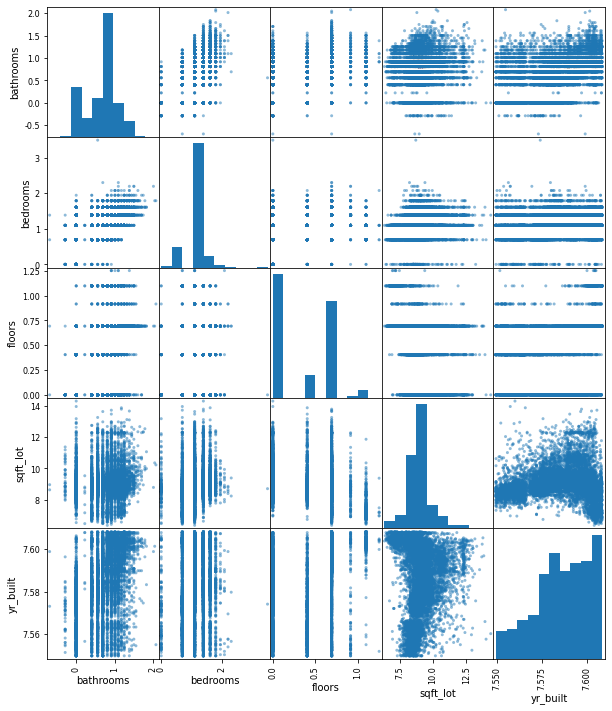

In [30]:
# log-transform non-normal features of Train Data
non_normal = ['bathrooms', 'bedrooms', 'floors', 'sqft_lot', 'yr_built']
train_preds_log = pd.DataFrame([])
train_preds_log[non_normal] = np.log(X_train_encoded[non_normal])
train_preds_log = pd.concat([train_preds_log.reset_index(drop=True), X_train_encoded.iloc[:,6:].reset_index(drop=True)], axis=1)

# log-transform non-normal features of Test Data
test_preds_log = pd.DataFrame([])
test_preds_log[non_normal] = np.log(X_test_encoded[non_normal])
test_preds_log = pd.concat([test_preds_log.reset_index(drop=True), X_test_encoded.iloc[:,6:].reset_index(drop=True)], axis=1)

# Visualize Impact of Logged Train Preds
pd.plotting.scatter_matrix(train_preds_log[non_normal], figsize=(10,12));

In [31]:
# Perform scaling of our training data utilizing StandardScaler
ss = StandardScaler()

X_train_scaled = ss.fit_transform(train_preds_log)
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=train_preds_log.index, columns=train_preds_log.columns)
X_train_scaled_df.head()

,bathrooms,bedrooms,floors,sqft_lot,yr_built,condition_Good,condition_Poor,condition_Very Good,grade_11 Excellent,grade_12 Luxury,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,-0.311462,-0.282324,-0.967464,0.398620,0.274225,1.674702,-0.038125,-0.292312,-0.138934,-0.062333,...,-0.116272,-0.051988,-0.143013,-0.109684,-0.112237,-0.108059,-0.110327,-0.085907,-0.110648,-0.121357
1,0.599230,-0.282324,-0.967464,3.206710,-0.131784,-0.597121,-0.038125,-0.292312,-0.138934,-0.062333,...,-0.116272,-0.051988,-0.143013,-0.109684,-0.112237,-0.108059,-0.110327,-0.085907,-0.110648,-0.121357
2,-0.705052,-1.711758,0.994292,1.124851,0.644242,-0.597121,-0.038125,-0.292312,-0.138934,-0.062333,...,-0.116272,-0.051988,-0.143013,-0.109684,-0.112237,-0.108059,-0.110327,-0.085907,-0.110648,-0.121357
3,-1.740318,1.518549,0.180090,0.372202,-1.920261,-0.597121,-0.038125,-0.292312,-0.138934,-0.062333,...,-0.116272,-0.051988,-0.143013,-0.109684,-0.112237,-0.108059,9.063949,-0.085907,-0.110648,-0.121357
4,1.458338,0.731875,0.994292,3.416798,1.112227,-0.597121,-0.038125,-0.292312,-0.138934,-0.062333,...,-0.116272,-0.051988,-0.143013,-0.109684,-0.112237,-0.108059,-0.110327,-0.085907,-0.110648,-0.121357


In [32]:
# Perform scaling of our test data utilizing StandardScaler
X_test_scaled = ss.fit_transform(test_preds_log)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=test_preds_log.index, columns=test_preds_log.columns)
X_test_scaled_df.head()

,bathrooms,bedrooms,floors,sqft_lot,yr_built,condition_Good,condition_Poor,condition_Very Good,grade_11 Excellent,grade_12 Luxury,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,-1.700255,-0.275331,-0.947796,-0.642114,-0.944843,1.674245,-0.033522,-0.292301,-0.133612,-0.068204,...,-0.116231,-0.050319,-0.149594,-0.107886,-0.112453,-0.111811,-0.111811,-0.065016,-0.122282,-0.123459
1,-0.279448,-0.275331,-0.947796,-0.737867,-1.813300,1.674245,-0.033522,-0.292301,-0.133612,-0.068204,...,-0.116231,-0.050319,-0.149594,-0.107886,-0.112453,-0.111811,-0.111811,-0.065016,-0.122282,-0.123459
2,1.089009,0.745458,1.032771,0.037071,1.261879,-0.597284,-0.033522,-0.292301,-0.133612,-0.068204,...,-0.116231,-0.050319,-0.149594,-0.107886,-0.112453,-0.111811,-0.111811,-0.065016,-0.122282,-0.123459
3,0.626113,-0.275331,1.032771,-0.022547,0.556847,-0.597284,-0.033522,-0.292301,-0.133612,-0.068204,...,-0.116231,-0.050319,-0.149594,-0.107886,-0.112453,-0.111811,-0.111811,-0.065016,-0.122282,-0.123459
4,-0.279448,-1.714052,-0.947796,-0.214100,-0.772493,-0.597284,-0.033522,-0.292301,-0.133612,-0.068204,...,-0.116231,-0.050319,-0.149594,-0.107886,-0.112453,-0.111811,8.943637,-0.065016,-0.122282,-0.123459


In [33]:
# add constant term/y-intercept to train data
X_train_preds = sm.add_constant(X_train_scaled_df)
X_test_preds = sm.add_constant(X_test_scaled_df)

In [34]:
# Reshape y_train to facilitate modeling against X_train
y_train=y_train.values.reshape(-1,1)
model = sm.OLS(endog=y_train, exog=X_train_preds).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     290.7
Date:                Wed, 22 Jun 2022   Prob (F-statistic):               0.00
Time:                        19:32:45   Log-Likelihood:                -81226.
No. Observations:               14469   AIC:                         1.626e+05
Df Residuals:                   14382   BIC:                         1.633e+05
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 264.0528      0.553    477.317      0.000     262.968     265.137
bathrooms             -15.9426      0.905    -17.625      0.000     -17.716     -14.170
bedrooms              -22.0767      0.694    -31.801      0.000     -23.437     -20.716
floors                 -0.9336      0.775     -1.205      0.228      -2.452       0.585
sqft_lot                5.1397      0.811      6.339      0.000       3.550       6.729
yr_built               -3.8493      0.937     -4.107      0.000      -5.686      -2.012
condition_Good          1.9832      0.627      3.163      0.002       0.754       3.212
condition_Poor         -2.4314      0.560     -4.339      0.000      -3.530      -1.333
condition_Very Good     5.5488      0.611      9.088      0.000       4.352       6.746
grade_11 Excellent      3.4254      0.644      5.316      0.000       2.163       4.688
grade_12 Luxury         5.0750      0.579      8.770      0.000       3.941       6.209
grade_13 Mansion        3.0331      0.560      5.419      0.000       1.936       4.130
grade_4 Low             0.0654      0.574      0.114      0.909      -1.060       1.191
grade_5 Fair           -5.2214      0.668     -7.815      0.000      -6.531      -3.912
grade_6 Low Average   -16.8936      1.137    -14.853      0.000     -19.123     -14.664
grade_7 Average       -27.8485      1.523    -18.286      0.000     -30.834     -24.863
grade_8 Good          -20.0554      1.292    -15.519      0.000     -22.589     -17.522
grade_9 Better         -7.8721      0.971     -8.110      0.000      -9.775      -5.970
zipcode_98002          -0.5273      0.689     -0.765      0.444      -1.878       0.824
zipcode_98003           0.4660      0.725      0.642      0.521      -0.956       1.888
zipcode_98004          36.6571      0.759     48.310      0.000      35.170      38.144
zipcode_98005          13.5655      0.673     20.152      0.000      12.246      14.885
zipcode_98006          22.0011      0.865     25.420      0.000      20.305      23.698
zipcode_98007          10.9115      0.646     16.883      0.000       9.645      12.178
zipcode_98008          17.6387      0.741     23.804      0.000      16.186      19.091
zipcode_98010           2.7453      0.626      4.384      0.000       1.518       3.973
zipcode_98011           7.6203      0.680     11.199      0.000       6.287       8.954
zipcode_98014           3.3501      0.648      5.168      0.000       2.079       4.621
zipcode_98019           5.1438      0.681      7.552      0.000       3.809       6.479
zipcode_98022           1.2845      0.708      1.814      0.070      -0.103       2.672
zipcode_98023          -0.6121      0.853     -0.718      0.473      -2.283       1.059
zipcode_98024           4.8719      0.619      7.866      0.000       3.658       6.086
zip

In [ ]:
### BReakpoint for reformatted Workbook.

## EDA - Junk to delete I think

In [ ]:
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
kc_encoded.hist(ax = ax);

In [ ]:
# scatter matrix
continuous_features = ['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'yr_built']
pd.plotting.scatter_matrix(kc_encoded[continuous_features], figsize=(10,12));

In [ ]:
# log-transform non-normal features
non_normal = ['bathrooms', 'bedrooms', 'floors', 'sqft_lot', 'yr_built']
kc_encoded_log = pd.DataFrame([])
kc_encoded_log[non_normal] = np.log(kc_encoded[non_normal])

kc_encoded_log.head()


pd.plotting.scatter_matrix(kc_encoded_log[non_normal], figsize=(10,12));

In [ ]:
# define X, y
X = kc_encoded.drop(columns=['price_sqft'])
y = kc_encoded['price_sqft']

In [ ]:
# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=41)

In [ ]:
#train_df = pd.concat([X_train, y_train], axis=1)

In [ ]:
#sns.pairplot(train_df)
#plt.show()

In [ ]:
# add constant term/y-intercept to train data
X_preds = sm.add_constant(X_train)

In [ ]:
# First model
model = sm.OLS(endog=y_train, exog=X_preds).fit()
model.summary()

In [ ]:
# Observations on 1st MultReg Model:
#     High pvalues:'grade_4 Low'
#     Solid R2 of 0.797
#     Coefficients hard to understand due to scaling.

In [ ]:
#train_df.corr()

In [ ]:
# Test for Multicolinearity

# defining an empty dataframe to capture the VIF scores
vif = pd.DataFrame()

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]

# label the scores with their related columns
vif["features"] = X_train.columns

vif

In [ ]:

from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train, y_train)

train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)

In [ ]:
# Check R2 for Train/Test data.
from sklearn.metrics import r2_score

print(f"Train R2: {r2_score(y_train, train_preds):.4f}")
print(f"Test R2: {r2_score(y_test, test_preds):.4f}")

In [ ]:
# Checking for normality

# Calculate our residuals
train_residuals = y_train - train_preds
test_residuals = y_test - test_preds

# QQ Plot
sm.qqplot(train_residuals, line = 'r');

In [ ]:
# Check Residual Plots

sns.residplot(x=X_train['bedrooms'], y=y_train)
plt.show()

sns.residplot(x=X_train['bathrooms'], y=y_train)
plt.show()

sns.residplot(x=X_train['sqft_lot'], y=y_train)
plt.show()

sns.residplot(x=X_train['floors'], y=y_train)
plt.show()

sns.residplot(x=X_train['yr_built'], y=y_train)
plt.show()


In [ ]:
# Might see some improvement if we get rid of our outliers in the bedrooms category. Relatively few that have > 8 rooms
# May improve our QQ plot as well.
kc_encoded.loc[kc_encoded['bedrooms'] > 8]

In [ ]:
#Might be worth removing properties with > 3 floors as well to improve homoskedasticity. only 7 outliers with >3.
kc_encoded.loc[kc_encoded['floors'] > 3]

## Adding Zipcode Feature

In [ ]:
# Re-read .csv Data
simple_housing_zip = pd.read_csv('../data/kc_house_data.csv')

# Redefine Complexities to exclude zipcode
complexities2 = ['id','date', 'view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

# Generate new DF inclusive of zipcode.
simple_housing_zip.drop(columns=complexities2, inplace=True)

# Add price per square foot feature
simple_housing_zip['price_sqft'] = simple_housing_zip['price'] / simple_housing_zip['sqft_living']

# drop waterfront & confirm no NaNs
simple_housing_zip.drop(columns=['waterfront','price','sqft_living'], inplace=True)
simple_housing_zip.isna().sum()

In [ ]:
# Include zipcode in our original list of categoricals & create new df with only the categorical columns.
categoricals2 = ['condition', 'grade', 'zipcode']
cat_df2 = simple_housing_zip[categoricals2]
cat_df2.head()

In [ ]:
# OneHot encoding for new categorical variables. Drop first column to avoid perfect multicolinearity.
ohe = OneHotEncoder(drop='first')
zip_cats = ohe.fit_transform(cat_df2)
zip_cats.todense()
zip_df = pd.DataFrame(zip_cats.todense(), columns=ohe.get_feature_names(categoricals2))
zip_df.head()

In [ ]:
# Drop origical categorical columns, concatenate encoded columns.
zip_data = simple_housing_zip.drop(columns=categoricals2)
kc_encoded_zip = pd.concat([zip_data.reset_index(drop=True), zip_df.reset_index(drop=True)], axis=1)

In [ ]:
kc_encoded_zip.shape

In [ ]:
non_normal = ['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'yr_built']
for feature in non_normal:
    kc_encoded_zip[feature] = kc_encoded_zip[feature].map(lambda x: np.log(x))
pd.plotting.scatter_matrix(kc_encoded_zip[non_normal], figsize=(10,12));

In [ ]:
# define X, y
X_zip = kc_encoded_zip.drop(columns=['price_sqft'])
y_zip = kc_encoded_zip['price_sqft']

# Train / Test split
X_zip_train, X_zip_test, y_zip_train, y_zip_test = train_test_split(
    X_zip, y_zip, test_size=0.33, random_state=41)

# add constant term/y-intercept to train data
X_zip_preds = sm.add_constant(X_zip_train)

In [ ]:
#2nd model with zip codes
model = sm.OLS(endog=y_zip_train, exog=X_zip_preds).fit()
model.summary()

In [ ]:
# Test for Multicolinearity

# defining an empty dataframe to capture the VIF scores
vif_zip = pd.DataFrame()

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score
vif_zip["VIF"] = [variance_inflation_factor(X_zip_train.values, i) for i in range(len(X_zip_train.columns))]

# label the scores with their related columns
vif_zip["features"] = X_zip_train.columns

vif_zip


In [ ]:
lr = LinearRegression()
lr.fit(X_zip_train, y_zip_train)

zip_train_preds = lr.predict(X_zip_train)
zip_test_preds = lr.predict(X_zip_test)

# Check R2 for Train/Test data.
print(f"Train R2: {r2_score(y_zip_train, zip_train_preds):.4f}")
print(f"Test R2: {r2_score(y_zip_test, zip_test_preds):.4f}")

In [ ]:
# Checking for normality

# Calculate our residuals
zip_train_residuals = y_zip_train - zip_train_preds
zip_test_residuals = y_zip_test - zip_test_preds

# QQ Plot
sm.qqplot(zip_train_residuals, line = 'r');

sm.qqplot(train_residuals, line = 'r');

In [ ]:
# Check Residual Plots

sns.residplot(x=X_zip_train['bedrooms'], y=y_zip_train)
plt.show()

sns.residplot(x=X_zip_train['bathrooms'], y=y_zip_train)
plt.show()

sns.residplot(x=X_zip_train['sqft_lot'], y=y_zip_train)
plt.show()

sns.residplot(x=X_zip_train['floors'], y=y_zip_train)
plt.show()

sns.residplot(x=X_zip_train['yr_built'], y=y_zip_train)
plt.show()

## Remove Bedrooms > 8

In [ ]:
kc_encoded_zip_br = kc_encoded_zip[kc_encoded_zip['bedrooms'] <= 8.0]

In [ ]:
kc_encoded_zip_br.shape

In [ ]:
# define X, y
X_zip_br = kc_encoded_zip.drop(columns=['price_sqft'])
y_zip_br = kc_encoded_zip['price_sqft']

# Train / Test split
X_zip_br_train, X_zip_br_test, y_zip_br_train, y_zip_br_test = train_test_split(
    X_zip_br, y_zip_br, test_size=0.33, random_state=41)

# add constant term/y-intercept to train data
X_zip__br_preds = sm.add_constant(X_zip_br_train)

In [ ]:
#3rd model without properties containing > 8 bedrooms
model = sm.OLS(endog=y_zip_train, exog=X_zip_preds).fit()
model.summary()

In [ ]:
zip_br_train_df = pd.concat([X_zip_br_train, y_zip_br_train], axis=1)

In [ ]:
zip_br_train_df.corr().price_sqft.sort_values(ascending=False)

In [ ]:
lr = LinearRegression()
lr.fit(X_zip_br_train, y_zip_br_train)

zip_br_train_preds = lr.predict(X_zip_br_train)
zip_br_test_preds = lr.predict(X_zip_br_test)

# Check R2 for Train/Test data.
print(f"Train R2: {r2_score(y_zip_br_train, zip_br_train_preds):.4f}")
print(f"Test R2: {r2_score(y_zip_br_test, zip_br_test_preds):.4f}")

In [ ]:
# Checking for normality

# Calculate our residuals
zip_br_train_residuals = y_zip_br_train - zip_br_train_preds
zip_test_residuals = y_zip_test - zip_test_preds

# QQ Plot
print('QQ Plot for <9 Bedrooms')
sm.qqplot(zip_br_train_residuals, line = 'r');

print('QQ Plot with all data')
sm.qqplot(train_residuals, line = 'r');

## Dropping Mansions from the Dataset

In [ ]:
kc_encoded_zip_br.loc[kc_encoded_zip_br['grade_13 Mansion'] == 1]

In [ ]:
kc_no_mansions = kc_encoded_zip_br.loc[kc_encoded_zip_br['grade_13 Mansion'] != 1]
kc_no_mansions.shape

In [ ]:
# define X, y
X_mansions = kc_no_mansions.drop(columns=['price_sqft'])
y_mansions = kc_no_mansions['price_sqft']

# Train / Test split
X_mansions_train, X_mansions_test, y_mansions_train, y_mansions_test = train_test_split(
    X_mansions, y_mansions, test_size=0.33, random_state=41)

# add constant term/y-intercept to train data
X_mansions_preds = sm.add_constant(X_mansions_train)

In [ ]:
#3rd model without properties containing > 8 bedrooms
model = sm.OLS(endog=y_mansions_train, exog=X_mansions_preds).fit()
model.summary()

In [ ]:
lr = LinearRegression()
lr.fit(X_mansions_train, y_mansions_train)

mansions_train_preds = lr.predict(X_mansions_train)
mansions_test_preds = lr.predict(X_mansions_test)

# Check R2 for Train/Test data.
print(f"Train R2: {r2_score(y_mansions_train, mansions_train_preds):.4f}")
print(f"Test R2: {r2_score(y_mansions_test, mansions_test_preds):.4f}")

In [ ]:
# QQ Plot
print('QQ Plot for <9 Bedrooms')
sm.qqplot(zip_br_train_residuals, line = 'r');

print('QQ Plot with all data')
sm.qqplot(train_residuals, line = 'r');

## Trying out Standard Scaler

In [ ]:
X_train_scaled

In [ ]:
X_train_scaled_df

In [ ]:
# Scaled Original Multilinear regression model.
X_train_scaled = sm.add_constant(X_train_scaled)
model = sm.OLS(endog=y_train, exog=X_train_scaled ).fit()
model.summary()

In [ ]:
y.hist();

In [ ]:
y_scld=np.log(y)
y_scld.hist();

In [ ]:
# Model with log-scaled y. R-squared degraded~3 points

X = X_preds
y = np.log(y_train)
model2 = sm.OLS(endog=y, exog=X).fit()
model2.summary()

In [ ]:
kc_encoded['grade_5 Fair'].sum()

In [ ]:
kc_encoded['grade_4 Low'].sum()

# Maybe drop since pvalues are 

In [ ]:
kc_encoded['condition_Poor'].sum()

# Maybe drop since pvalues are very high and minimal number of properties.

In [ ]:
kc_encoded['grade_8 Good'].sum()

# Too big a population to drop.

In [ ]:
# Model with log-scaled y, and dropped high pvalue columns

X = train_df.drop(columns=['price_sqft', 'floors', 'condition_Poor', 'grade_13 Mansion', 'grade_8 Good', 'grade_4 Low', 'grade_3 Poor'])
y = np.log(train_df['price_sqft'])
model3 = sm.OLS(endog=y, exog=X).fit()
model3.summary()

## Visualizing

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(16,20))


for xcol, ax in zip(kc_encoded.columns[:], [x for v in axes for x in v]):
    kc_encoded.plot.scatter(x=xcol, y='price_sqft', ax=ax, alpha=0.5, color='b')


In [ ]:
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
kc_encoded.hist(ax = ax);

# Full EDA

In [ ]:
kc_housing = pd.read_csv('../data/kc_house_data.csv')


In [ ]:
kc_housing.shape

In [ ]:
kc_housing.describe()

In [ ]:
columns_of_note = list(kc_housing.columns)[3:8]

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,16))


for xcol, ax in zip(kc_housing.columns[3:8], [x for v in axes for x in v]):
    kc_housing.plot.scatter(x=xcol, y='price', ax=ax, alpha=0.5, color='b')


In [ ]:
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
kc_housing.hist(ax = ax);

In [ ]:
kc_housing.info()

In [ ]:
# Looking for NANs
kc_housing.isna().sum()

#### Added price/sqft feature

In [ ]:
kc_housing['price_sqft'] = kc_housing['price']/kc_housing['sqft_living']

In [ ]:
kc_housing.head()

#### Addressing Waterfront

There are ~2400 NA cells, no easy way to determine if waterfront or not. Recommend we drop this whole column--even if all of the NA cells should be YES for waterfront, that's less than 10% of our dataset, likely not meaningful to our analysis.

Drop Waterfront.

In [ ]:
kc_housing['waterfront'].value_counts()

In [ ]:
sum(kc_housing['waterfront'].isna())

In [ ]:
kc_housing['waterfront'] = kc_housing['waterfront'].fillna('N/A')

In [ ]:
kc_housing.sort_values(by='waterfront', ascending=False)

#### Addressing View

Doesn't seem to be many rows with na. Maybe encode as NA or preferably drop?+

Drop rows with N/A

In [ ]:
sum(kc_housing['view'].isna())

In [ ]:
kc_housing['view'].value_counts()

In [ ]:
# code to replace empty with N/A - add inplace if we decide to take this approach.
kc_housing['view'] = kc_housing['view'].fillna('N/A')

#### Addressing yr_renovated

Absent from simple data, maybe we add on later

~ 78% have 0 values, so assume they were not rennovated. I think rennovations are a meaningful datapoint, so we should encode this somehow. We could think about how recent the rennovation was to see if there is a meaningful relationship--for example, a home rennovated in 2020 is likely to sell better than a home rennovated only in 1980. Maybe we do some research on this and decide on a breakpoint for rennovated before/after? We could do a simple linear regression between yr renovated and price...

In [ ]:
sum(kc_housing['yr_renovated'].isna())

In [ ]:
kc_housing['yr_renovated'].value_counts(sort=False).head(75)

In [ ]:
kc_housing['yr_renovated'] = kc_housing['yr_renovated'].fillna('N/A')

In [ ]:
#dropping N/A for now to make model function.
kc_housing = kc_housing[(kc_housing.yr_renovated != 'N/A')]

#### Duplicate Properties

In [ ]:
# Looking for duplicate properties

kc_housing['id'].duplicated().sum()

In [ ]:
# Identify instances of the same property appearing more than once in the data set based on lattitude, longitude
# How do we treat this? Might not matter since there is only ~4-5 months of data here. as long as listing date 
# is different, probably OK to treat these as unique listings.


kc_housing[kc_housing.duplicated(subset=['id'], keep=False)].sort_values('id')

#### Addressing grade

This we need to encode as an ordinal.

In [ ]:
kc_housing['grade'].value_counts()

In [ ]:
# Create new column for numerical grade. 
# Should either drop df['grade'] or omit it from clean df.
kc_housing['grade_num']= kc_housing['grade'].apply(lambda x: x[:1]).astype(int)

In [ ]:
kc_housing['grade_num']

In [ ]:
kc_housing.info()

#### Addressing sqft_basement

Recommend we drop rows with N/A since we don't have an easy way to encode.
We have 454 unknown values here. need to drop or encode somehow. Maybe has basement or no basement?


In [ ]:
kc_housing['sqft_basement'].value_counts()

In [ ]:
kc_housing = kc_housing[(kc_housing.sqft_basement != '?')]

In [ ]:
kc_housing['sqft_basement'].value_counts()

# Encoding Categoricals

In [ ]:
# Identify catgeorical values & create new df with only the categorical columns.
categoricals = ['bedrooms', 'floors', 'condition', 'grade', 'view','waterfront']
cat_df = kc_housing[categoricals]
cat_df.head()

In [ ]:
# OneHot encoding for categorical variables. Drop first column to avoid perfect multicolinearity.
ohe = OneHotEncoder(drop='first')
categorical_cats = ohe.fit_transform(cat_df)
categorical_cats.todense()
categorical_df = pd.DataFrame(categorical_cats.todense(), columns=ohe.get_feature_names(categoricals))
categorical_df.head()

In [ ]:
categorical_df.shape

In [ ]:
kc_housing.shape

In [ ]:
# Append categorical dummies to original dataframe, and drop origical categorical columns.
data = kc_housing.drop(columns=categoricals)
kc_encoded = pd.concat([data.reset_index(drop=True), categorical_df.reset_index(drop=True)], axis=1)

In [ ]:
kc_encoded.shape

In [ ]:
kc_encoded.info()

# Nonsense Model with all columns

In [ ]:
X = kc_encoded.drop(columns=['date', 'lat', 'long', 'id','price_sqft','yr_renovated','sqft_basement'])
y = kc_encoded['price_sqft']

In [ ]:
X.isna().sum()

In [ ]:

model = sm.OLS(endog=y, exog=X).fit()
model.summary()